Попов Илья Павлович, М8О-109СВ-24

# Установка библиотек

In [21]:
!pip3 install xgboost shap lime optuna

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular

## Загружаем датасет с ценами автомобилей

In [25]:
import kagglehub
import os

path = kagglehub.dataset_download("CooperUnion/cardataset")
file_path = os.path.join(path, "data.csv")
df = pd.read_csv(file_path)
print("Первые 5 строк датасета:")
df.head()


Make       Model  Year             Engine Fuel Type  Engine HP  \
0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
1  BMW    1 Series  2011  premium unleaded (required)      300.0   
2  BMW    1 Series  2011  premium unleaded (required)      300.0   
3  BMW    1 Series  2011  premium unleaded (required)      230.0   
4  BMW    1 Series  2011  premium unleaded (required)      230.0   

   Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
0               6.0            MANUAL  rear wheel drive              2.0   
1               6.0            MANUAL  rear wheel drive              2.0   
2               6.0            MANUAL  rear wheel drive              2.0   
3               6.0            MANUAL  rear wheel drive              2.0   
4               6.0            MANUAL  rear wheel drive              2.0   

                         Market Category Vehicle Size Vehicle Style  \
0  Factory Tuner,Luxury,High-Performance      Compact         Coupe   
1                     Luxury,Performance      Compact   Convertible   
2                Luxury,High-Performance      Compact         Coupe   
3                     Luxury,Performance      Compact         Coupe   
4                                 Luxury      Compact   Convertible   

   highway MPG  city mpg  Popularity   MSRP  
0           26        19        3916  46135  
1           28        19        3916  40650  
2           28        20        3916  36350  
3           28        18        3916  29450  
4           28        18        3916  34500

# Предобработка данных



 Оставляем только нужные колонки и удаляем пропуски

 Обрабатываем целевую переменную (MSRP - цена автомобиля)
 Удаляем нечисловые символы и преобразуем в float

 Кодируем категориальные признаки:
 - Vehicle Style преобразуем через LabelEncoder
 - Make (марка авто) через OneHotEncoding

In [65]:
df = df[['Make', 'Vehicle Style', 'Engine HP', 'city mpg', 'MSRP']].dropna()

# цена автомобиля
if not pd.api.types.is_numeric_dtype(df['MSRP']):
    df['MSRP'] = pd.to_numeric(df['MSRP'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')
y = df['MSRP'].dropna()

# категориальные признаки
df['Vehicle Style'] = LabelEncoder().fit_transform(df['Vehicle Style'])
ct = ColumnTransformer(
    [('onehot', OneHotEncoder(handle_unknown='ignore'), ['Make'])],
    remainder='passthrough'
)
X = ct.fit_transform(df[['Make', 'Vehicle Style', 'Engine HP', 'city mpg']])
feature_names = list(ct.named_transformers_['onehot'].categories_[0]) + ['Vehicle Style', 'Engine HP', 'city mpg']
X = pd.DataFrame(X.toarray(), columns=feature_names)

print("X shape:", X.shape)
print("y shape:", y.shape)
display(X.head())


X shape: (11845, 50)
y shape: (11845,)


Acura  Alfa Romeo  Aston Martin  Audi  BMW  Bentley  Bugatti  Buick  \
0    0.0         0.0           0.0   0.0  1.0      0.0      0.0    0.0   
1    0.0         0.0           0.0   0.0  1.0      0.0      0.0    0.0   
2    0.0         0.0           0.0   0.0  1.0      0.0      0.0    0.0   
3    0.0         0.0           0.0   0.0  1.0      0.0      0.0    0.0   
4    0.0         0.0           0.0   0.0  1.0      0.0      0.0    0.0   

   Cadillac  Chevrolet  ...  Scion  Spyker  Subaru  Suzuki  Toyota  \
0       0.0        0.0  ...    0.0     0.0     0.0     0.0     0.0   
1       0.0        0.0  ...    0.0     0.0     0.0     0.0     0.0   
2       0.0        0.0  ...    0.0     0.0     0.0     0.0     0.0   
3       0.0        0.0  ...    0.0     0.0     0.0     0.0     0.0   
4       0.0        0.0  ...    0.0     0.0     0.0     0.0     0.0   

   Volkswagen  Volvo  Vehicle Style  Engine HP  city mpg  
0         0.0    0.0            8.0      335.0      19.0  
1         0.0    0.0            6.0      300.0      19.0  
2         0.0    0.0            8.0      300.0      20.0  
3         0.0    0.0            8.0      230.0      18.0  
4         0.0    0.0            6.0      230.0      18.0  

[5 rows x 50 columns]

# Разделение данных и обучение модели

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=69420
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=69420
)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    max_depth = trial.suggest_int('max_depth', 2, 500)
    max_leaves = trial.suggest_int('max_leaves', 1, 1000)

    xgbr = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_leaves=max_leaves,
        learning_rate=0.1,
        random_state=69420
    )
    xgbr.fit(X_train, y_train)
    pred = xgbr.predict(X_val)
    return mean_absolute_error(pred, y_val)

# гиперпараметры
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(),
    pruner=SuccessiveHalvingPruner()
)
study.optimize(objective, n_trials=100)

# лучшие параметры
best = study.best_params
print(f"\nЛучшие параметры: {best}")

# обучаем финальную модель с лучшими параметрами
xgbr = XGBRegressor(
    n_estimators=best['n_estimators'],
    max_depth=best['max_depth'],
    max_leaves=best['max_leaves'],
    learning_rate=0.1,
    random_state=69420
)
xgbr.fit(X_train, y_train)
pred = xgbr.predict(X_test)


[I 2025-06-01 09:56:58,176] A new study created in memory with name: no-name-214cb2f2-524b-4fc0-8177-4ac18c108910
[I 2025-06-01 09:56:58,372] Trial 0 finished with value: 5615.9345703125 and parameters: {'n_estimators': 33, 'max_depth': 138, 'max_leaves': 273}. Best is trial 0 with value: 5615.9345703125.
[I 2025-06-01 09:56:59,512] Trial 1 finished with value: 4279.509765625 and parameters: {'n_estimators': 97, 'max_depth': 175, 'max_leaves': 958}. Best is trial 1 with value: 4279.509765625.
[I 2025-06-01 09:56:59,659] Trial 2 finished with value: 7675.53125 and parameters: {'n_estimators': 18, 'max_depth': 174, 'max_leaves': 390}. Best is trial 1 with value: 4279.509765625.
[I 2025-06-01 09:57:02,195] Trial 3 finished with value: 4417.32373046875 and parameters: {'n_estimators': 54, 'max_depth': 66, 'max_leaves': 761}. Best is trial 1 with value: 4279.509765625.
[I 2025-06-01 09:57:02,324] Trial 4 finished with value: 9702.8291015625 and parameters: {'n_estimators': 13, 'max_depth': 


Лучшие параметры: {'n_estimators': 98, 'max_depth': 479, 'max_leaves': 469}


# Анализ результатов

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Ground truth', color='red')
sns.kdeplot(pred, label='Predicted', color='blue')
plt.title('Распределение предсказанных и реальных цен')
plt.legend()
plt.show()

Вывод: Модель хорошо улавливает общую тенденцию, но есть расхождения в области высоких цен (хвост распределения)

# SHAP визуализация (минимальная версия)

## 1. Summary Plot


Summary Plot


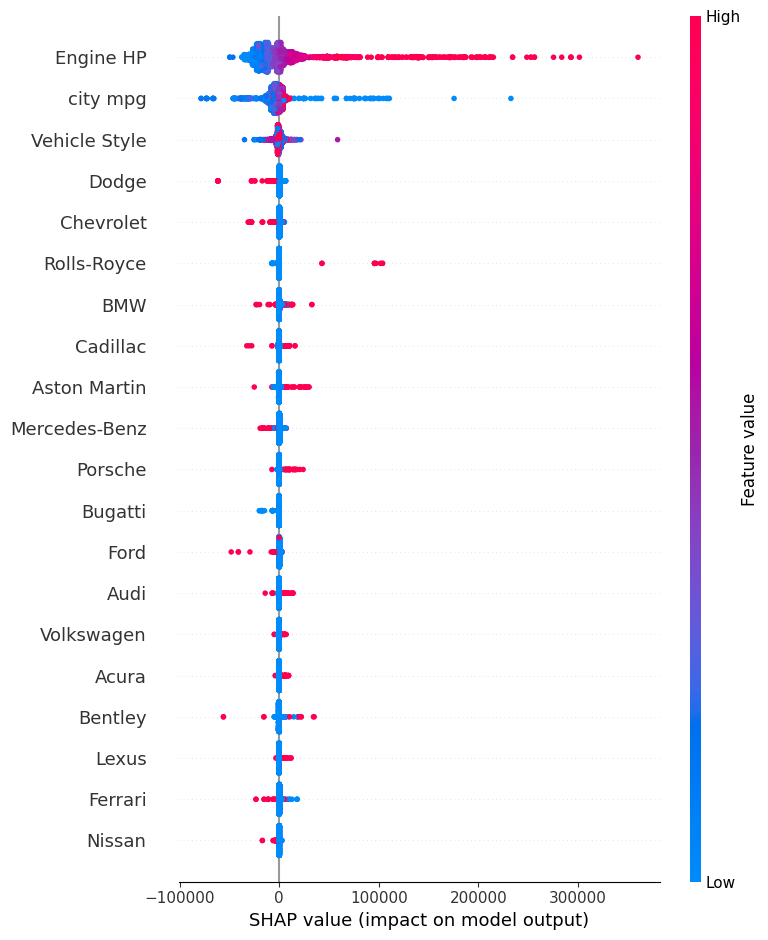

<Figure size 640x480 with 0 Axes>

In [69]:
print("\nSummary Plot")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
plt.tight_layout()
plt.show()

Вывод: Наибольшее влияние на цену оказывают:
- Мощность двигателя (Engine HP)
- Расход топлива в городе (city mpg)

### 2. Bar Plot (важность признаков)


Bar Plot (важность признаков)


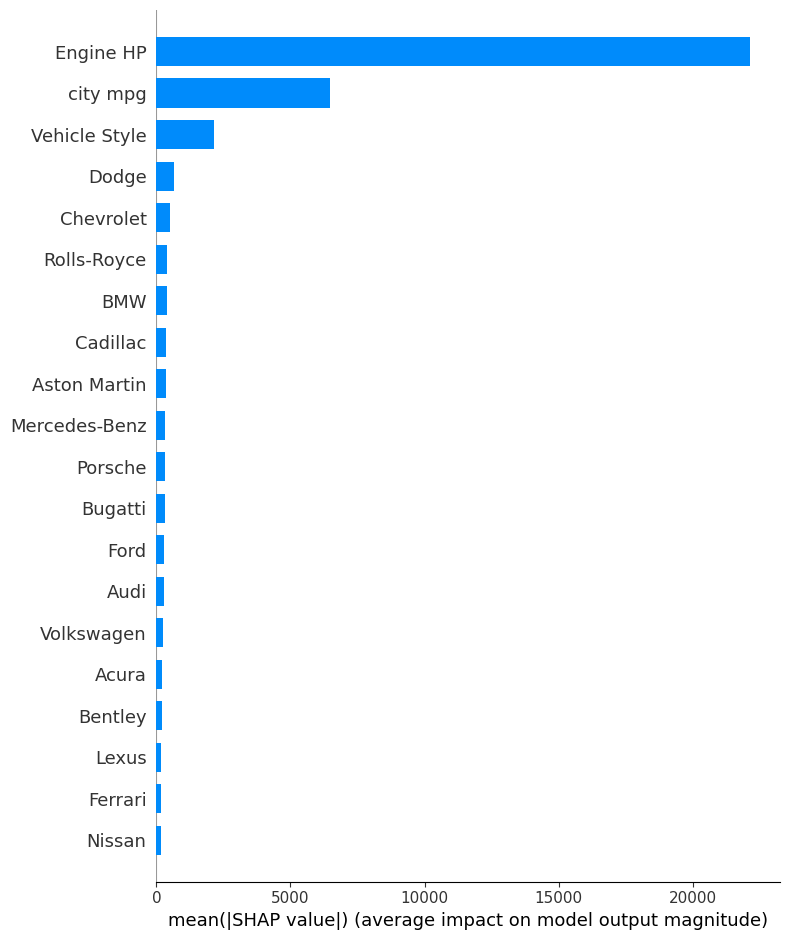

<Figure size 640x480 with 0 Axes>

In [67]:
print("\nBar Plot (важность признаков)")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")
plt.tight_layout()
plt.show()

## 3. Dependence Plot для Engine HP


Dependence Plot для Engine HP


<Figure size 1000x600 with 0 Axes>

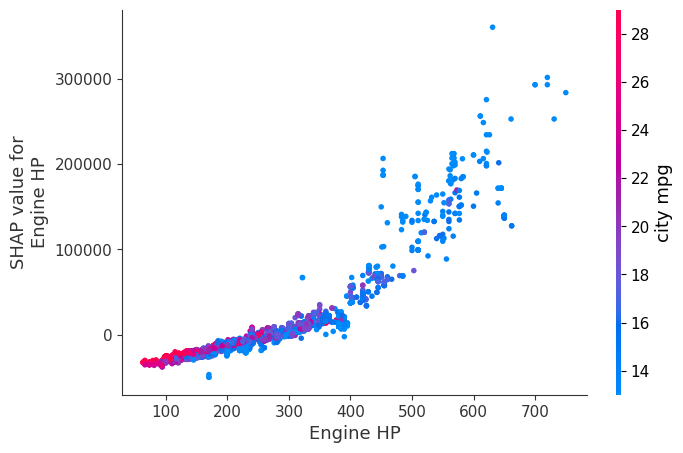

In [68]:
# 3. Dependence Plot для Engine HP
print("\nDependence Plot для Engine HP")
plt.figure(figsize=(10, 6))
shap.dependence_plot("Engine HP", shap_values, X_test, feature_names=feature_names)
plt.show()

Вывод: Чем больше мощность двигателя, тем выше цена автомобиля.
Интересно, что для мощных двигателей (>400 л.с.) разброс цен увеличивается, что может быть связано с разными классами автомобилей (спортивные, люксовые и т.д.)


# Локальная интерпретация с LIME

In [74]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    mode='regression',
    random_state=69420
)

# первый автомобиль из тестовой выборки
sample_car = X_test.iloc[0]
original_price = xgbr.predict([sample_car])[0]
print(f"Исходная предсказанная цена: ${original_price:,.2f}\n")

Исходная предсказанная цена: $25,820.23



In [75]:
# Анализируем исходные параметры автомобиля
print("Анализируем первый автомобиль в тестовой выборке:")
exp = explainer_lime.explain_instance(
    sample_car.values,
    xgbr.predict,
    num_features=10
)
exp.show_in_notebook(show_all=True)

Анализируем первый автомобиль в тестовой выборке:


Из этого объяснения видно, что:
- Марка BMW существенно увеличивает предсказанную цену
- Высокая мощность двигателя (335 л.с.) дает основной вклад в цену
- Относительно высокий расход топлива (19 mpg) немного снижает стоимость

In [76]:
# "Поколдуем" над параметрами - сделаем из BMW экономичный автомобиль
modified_car = sample_car.copy()
modified_car['BMW'] = 0  # Меняем марку с BMW на другую
modified_car['Engine HP'] = 150  # Уменьшаем мощность
modified_car['city mpg'] = 30  # Улучшаем расход топлива

modified_price = xgbr.predict([modified_car])[0]
print(f"\nПосле изменений (BMW -> другая марка, 150 л.с., 30 mpg):")
print(f"Новая предсказанная цена: ${modified_price:,.2f}")
print(f"Разница: ${original_price-modified_price:,.2f} ({((original_price-modified_price)/original_price*100):.1f}% снижения)")

exp_modified = explainer_lime.explain_instance(
    modified_car.values,
    xgbr.predict,
    num_features=10
)
exp_modified.show_in_notebook(show_all=True)


После изменений (BMW -> другая марка, 150 л.с., 30 mpg):
Новая предсказанная цена: $22,232.23
Разница: $3,588.01 (13.9% снижения)


Теперь видим:
- Отсутствие марки BMW значительно снижает цену
- Мощность двигателя теперь дает меньший вклад
- Улучшенный расход топлива положительно влияет на стоимость

In [73]:
# Создадим "люксовый" вариант
luxury_car = sample_car.copy()
luxury_car['Mercedes-Benz'] = 1  # Меняем на Mercedes
luxury_car['Engine HP'] = 450  # Увеличиваем мощность
luxury_car['city mpg'] = 15  # Ухудшаем расход

luxury_price = xgbr.predict([luxury_car])[0]
print(f"\nЛюксовый вариант (Mercedes, 450 л.с., 15 mpg):")
print(f"Предсказанная цена: ${luxury_price:,.2f}")
print(f"Разница: ${luxury_price-original_price:,.2f} ({((luxury_price-original_price)/original_price*100):.1f}% увеличения)")

exp_luxury = explainer_lime.explain_instance(
    luxury_car.values,
    xgbr.predict,
    num_features=10
)
exp_luxury.show_in_notebook(show_all=True)


Люксовый вариант (Mercedes, 450 л.с., 15 mpg):
Предсказанная цена: $75,659.32
Разница: $49,839.09 (193.0% увеличения)


Можно заметить:
1. Марка автомобиля имеет огромное значение - переход от BMW к Mercedes при прочих равных дает увеличение цены
2. Мощность двигателя - ключевой фактор: увеличение с 335 до 450 л.с. существенно повышает стоимость

# Выводы

Модель XGBoost успешно предсказывает цены на автомобили, демонстрируя хорошую точность для большинства сегментов, хотя для премиальных моделей с высокой стоимостью точность снижается из-за ограниченного количества данных. Ключевыми факторами ценообразования стали мощность двигателя, марка автомобиля и расход топлива, причем премиальные бренды и высокая мощность значительно увеличивают стоимость, в то время как экономичные модели с хорошим расходом топлива оказывают обратный эффект на итоговую цену.